In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense
from sklearn.preprocessing import LabelEncoder

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2024-05-02 23:34:49--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  25.3MB/s    in 0.2s    

2024-05-02 23:34:50 (25.3 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [39]:
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=['User ID', 'Movie ID', 'Rating', 'Timestamp'])


In [35]:
# Drop the Timestamp column
ratings_df.drop('Timestamp', axis=1, inplace=True)

# Display the first few rows of the dataset
print("Shape of ratings dataset:", ratings_df.shape)
ratings_df.head()

Shape of ratings dataset: (100000, 6)


,User ID,Movie ID,Rating,Genre 1,Genre 2,Genre 3
0,196,242,3,NaN,NaN,NaN
1,186,302,3,NaN,NaN,NaN
2,22,377,1,NaN,NaN,NaN
3,244,51,2,NaN,NaN,NaN
4,166,346,1,NaN,NaN,NaN


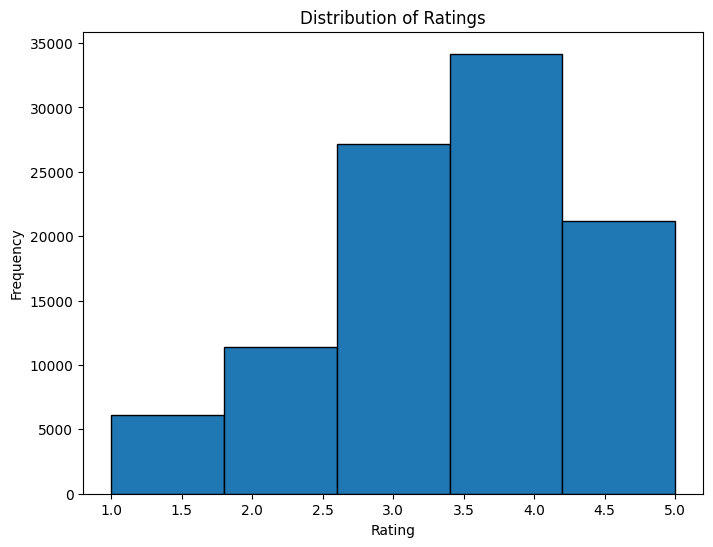

In [44]:
# Distribution of Ratings
plt.figure(figsize=(8, 6))
plt.hist(ratings_df['Rating'], bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

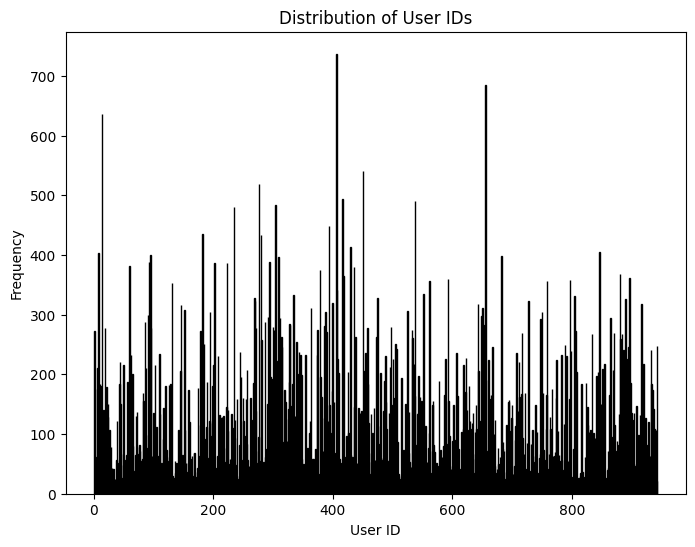

In [45]:
# User Distribution
plt.figure(figsize=(8, 6))
plt.hist(ratings_df['User ID'], bins=range(0, max(ratings_df['User ID'])+1), edgecolor='black')
plt.xlabel('User ID')
plt.ylabel('Frequency')
plt.title('Distribution of User IDs')
plt.show()

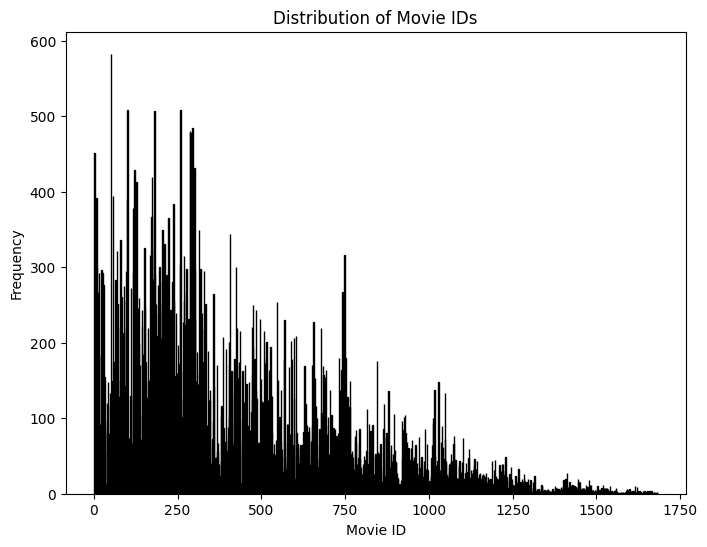

In [46]:
# Movie Distribution
plt.figure(figsize=(8, 6))
plt.hist(ratings_df['Movie ID'], bins=range(0, max(ratings_df['Movie ID'])+1), edgecolor='black')
plt.xlabel('Movie ID')
plt.ylabel('Frequency')
plt.title('Distribution of Movie IDs')
plt.show()

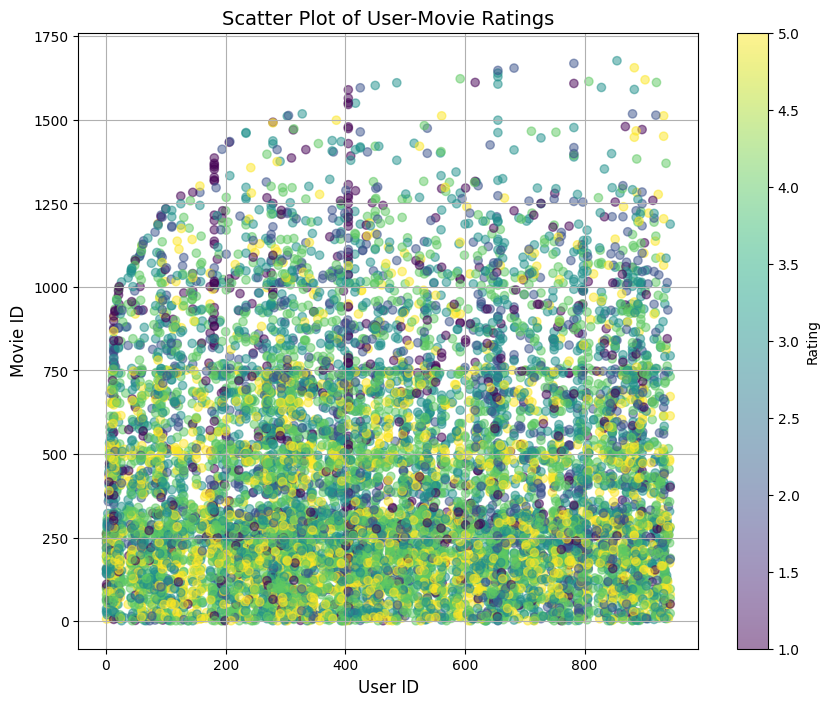

In [59]:

sample_size = 10000  
ratings_sample = ratings_df.sample(n=sample_size, random_state=42)

# Plot scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(ratings_sample['User ID'], ratings_sample['Movie ID'], c=ratings_sample['Rating'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Rating')
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Movie ID', fontsize=12)
plt.title('Scatter Plot of User-Movie Ratings', fontsize=14)
plt.grid(True)
plt.show()

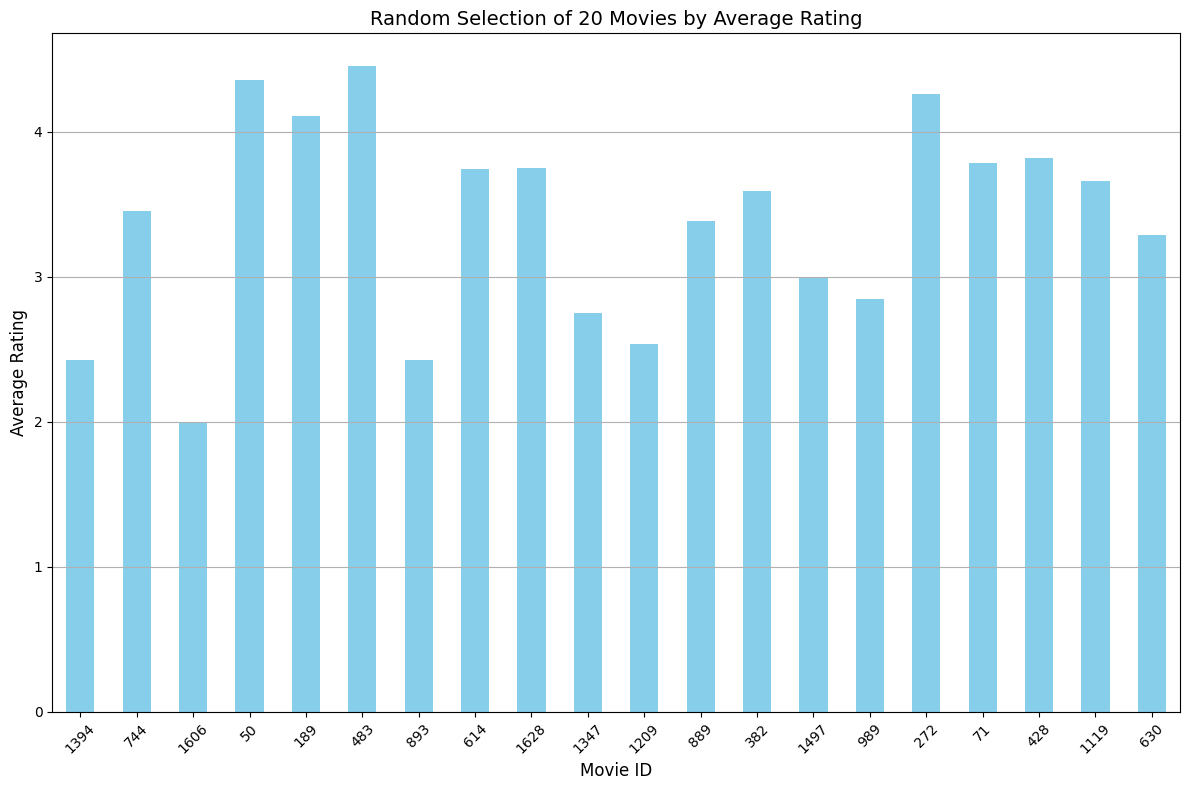

In [63]:
# Calculate average rating for each movie
average_ratings = ratings_df.groupby('Movie ID')['Rating'].mean()

# Shuffle the DataFrame and select 20 random movies
random_top_movies = average_ratings.sample(n=20, random_state=42)

# Plot bar plot
plt.figure(figsize=(12, 8))
random_top_movies.plot(kind='bar', color='skyblue')
plt.xlabel('Movie ID', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.title('Random Selection of 20 Movies by Average Rating', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to prevent labels from getting cut off
plt.show()

In [7]:
# Encode User ID and Movie ID
user_encoder = LabelEncoder()
ratings_df['user_id'] = user_encoder.fit_transform(ratings_df['User ID'])

In [8]:
movie_encoder = LabelEncoder()
ratings_df['movie_id'] = movie_encoder.fit_transform(ratings_df['Movie ID'])

In [9]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)


In [10]:
# Number of unique users and movies
num_users = len(ratings_df['user_id'].unique())
num_movies = len(ratings_df['movie_id'].unique())


In [11]:
print(num_movies)

1682


In [12]:
print(num_users)

943


In [13]:
# Collaborative Filtering Model with Regression
# User input
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users, output_dim=50)(user_input)
user_embedding = Flatten()(user_embedding)

In [14]:
# Movie input
movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(input_dim=num_movies, output_dim=50)(movie_input)
movie_embedding = Flatten()(movie_embedding)

In [15]:
# Dot product of user and movie embeddings
dot_product = Dot(axes=1)([user_embedding, movie_embedding])

# Concatenate user and movie embeddings
concat = Concatenate()([user_embedding, movie_embedding])

# Fully connected layers
dense1 = Dense(128, activation='relu')(concat)
dense2 = Dense(64, activation='relu')(dense1)

In [16]:
# Output layer
output = Dense(1, activation='sigmoid')(dense2)  # Sigmoid activation for regression

# Model
model = Model(inputs=[user_input, movie_input], outputs=output)

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [18]:
# Train the model
history = model.fit(x=[train_df['user_id'], train_df['movie_id']], y=train_df['Rating'],
                    validation_data=([test_df['user_id'], test_df['movie_id']], test_df['Rating']),
                    epochs=5, batch_size=64)

Epoch 1/5
1250/1250 [==============================] - 13s 8ms/step - loss: 7.7490 - val_loss: 7.6349
Epoch 2/5
1250/1250 [==============================] - 6s 5ms/step - loss: 7.6754 - val_loss: 7.6349
Epoch 3/5
1250/1250 [==============================] - 5s 4ms/step - loss: 7.6754 - val_loss: 7.6349
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 7.6754 - val_loss: 7.6349
Epoch 5/5
1250/1250 [==============================] - 6s 5ms/step - loss: 7.6754 - val_loss: 7.6349


In [19]:
# Evaluate the model
predictions = model.predict([test_df['user_id'], test_df['movie_id']])
mse = mean_squared_error(test_df['Rating'], predictions)
print('Mean Squared Error:', mse)

625/625 [==============================] - 1s 2ms/step
Mean Squared Error: 7.634850798615906


In [22]:
def recommend_movies_for_user(user_id, num_recommendations=10):
    # Load movie titles
    movies_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None)
    movie_titles = movies_df[[0, 1]].rename(columns={0: 'Movie ID', 1: 'Title'})

    # Creating an array of movie IDs for all movies in the dataset
    all_movie_ids = np.array(range(num_movies))

    # Repeat the user ID for each movie to create input data
    user_ids_input = np.array([user_id] * len(all_movie_ids))

    # Using the model to predict ratings for all movies for the specified user
    predicted_ratings = model.predict([user_ids_input, all_movie_ids])

    # Create a DataFrame to store movie IDs, names, and predicted ratings
    ratings_df = pd.DataFrame({'Movie ID': all_movie_ids, 'Predicted Rating': predicted_ratings.flatten()})

    # Merge with movie titles to get movie names
    ratings_df = pd.merge(ratings_df, movie_titles, on='Movie ID')

    # Sort the DataFrame by predicted ratings in descending order
    top_recommendations = ratings_df.sort_values(by='Predicted Rating', ascending=False)

    # Get the top N recommended movies
    recommendations = top_recommendations.head(num_recommendations)

    return recommendations

In [25]:
user_id = 17 #any userid
recommendations = recommend_movies_for_user(user_id)
print("Top 10 recommended movies for user", user_id)
print(recommendations[['Title', 'Predicted Rating']])

53/53 [==============================] - 0s 2ms/step
Top 10 recommended movies for user 17
                                               Title  Predicted Rating
0                                   Toy Story (1995)               1.0
548                                   Rob Roy (1995)               1.0
1457                    Damsel in Distress, A (1937)               1.0
1103           C'est arrivé près de chez vous (1992)               1.0
541                                Pocahontas (1995)               1.0
1102                                    Trust (1990)               1.0
543   Things to Do in Denver when You're Dead (1995)               1.0
544                       Vampire in Brooklyn (1995)               1.0
1100                Six Degrees of Separation (1993)               1.0
546            Young Poisoner's Handbook, The (1995)               1.0
